In [89]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
datadir = './data'

Populating the interactive namespace from numpy and matplotlib


# Plotting Subway Delay and Ridership Information
This notebook plots the relationship between ridership and subway delays on a per station basis for 2015.

## First, create a filter to only use Yonge-University-Spadina and Bloor-Danforth Stations

These are the two most used lines.

In [3]:
yus = ['downsview','wilson','yorkdale','lawrence west','glencairn','eglinton west','st clair west','dupont','spadina','st george','museum',"queen's park",'st patrick','osgoode','st andrew','union','king','queen','dundas','college','wellesley','bloor','rosedale','summerhill','st clair','davisville','eglinton','lawrence','york mills','sheppard','north york centre','finch']
bd = ['kipling','islington','royal york','old mill','jane','runnymede','high park','keele','dundas west','lansdowne','dufferin','ossington','christie','bathurst','spadina','st george','bay','yonge','sherbourne','castle frank','broadview','chester','pape','donlands','greenwood','coxwell','woodbine','main street','victoria park','warden','kennedy']
interchange = ['spadina','st george','bloor','yonge'] # bloor-yonge is just one interchange, but it has different names on each line

## Import Ridership Information

In [4]:
ridership = np.loadtxt('{0}/ridership_2015.csv'.format(datadir),delimiter=',',skiprows=3,dtype=str)
station = ridership[:,1]
totrain = ridership[:,2]
fromtrain = ridership[:,3]
total = ridership[:,4]

## Import Delay Code Information

In [5]:
delayinfo = np.loadtxt('{0}/delay_codes_2014-2017.csv'.format(datadir),delimiter=',',skiprows=1,dtype='str')

# Columns-> 0:date, 1:time, 2:day, 3:location, 4:code, 5:delay time, 6:train gap time, 7:train direction, 8:line, 9:vehicle number

# Mask for known codes and only the YUS and BD lines
mask = (delayinfo[:,8]!='SRT') & (delayinfo[:,9]!='SHP') & (delayinfo[:,4]!='XXXXX') & (delayinfo[:,4]!='XXXXXX')
delayinfo=delayinfo[mask]

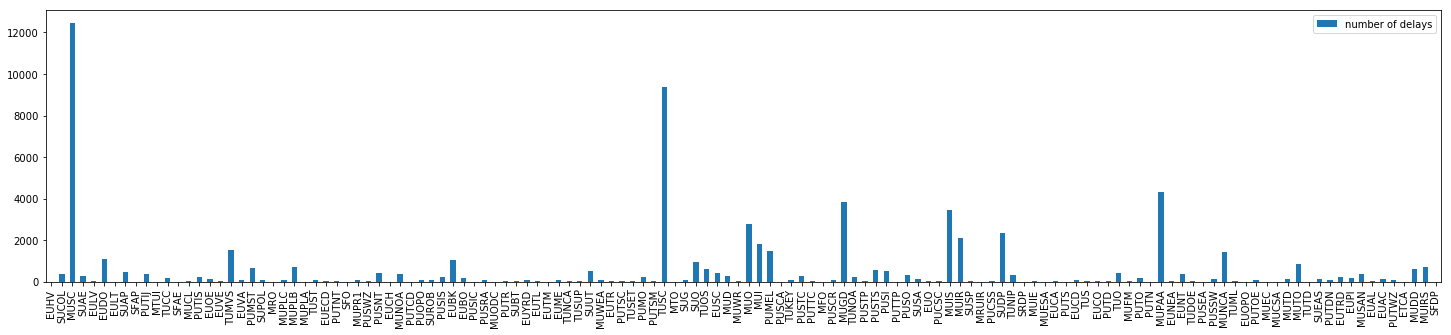

In [6]:
import pandas
from collections import Counter
code_counts = Counter(delayinfo[:,4])
df = pandas.DataFrame.from_dict(code_counts, orient='index')
df.columns=['number of delays']
df.plot(kind='bar',figsize=(25,5))

In [83]:
# Interpret delay codes
train = ['EUBO','EUAC','EUDO','EUTRD','MUODC','MUSAN','PUOPO','PUSCR','TUDOE','TUSET','TUST']
employee = ['EUME','EUOE','MUCL','MUESA','MUIE','MULD','MUNOA','MUTD','MUWR','SUAE','TUCC','TUMVS','TUNIP','TUNOA','TUOPO','TUOS','TUS','TUSC','TUSUP']
signals = ['PUCSC','PUCSS','PUSI','PUSIS','PUSNT','PUSO','PUSSW','PUSTS','PUSWZ','PUTSC']
track = ['EUHV','EULT','EULV','PUTD','PUTDN','PUTR','PUTS','PUTSM','PUTTC','PUTTP','PUTWZ']
station_prob = ['PUMEL','PUMO','PUMST','SUCOL','SUEAS']
other_mech = ['EUAL','EUCH','EUCO','EUNEA','EUNT','EUO','EUOPO','EUPI','EUSC','EUTL','EUTM','EUTR','EUVA','EUVE','EUYRD','MUEC','MUFM','PUSCA','PUSRA','PUSTP','PUTCD','PUTNT','PUTO','PUTOE','TUKEY']
passenger = ['MUD','MUDD','MUI','MUIR','MUIRS','MUIS','MUPAA','MUPR1','SUAP','SUBT','SUDP','SUG','SUO','SUPOL','SUROB','SUSA','SUSP','SUUT']
weather = ['MUWEA','PUTIS']
misc = ['MUGD','MUO','MULPA','MUPLB','MUPLC','MUSC','MUTO','PUSEA','TUML','TUO']


In [84]:
def station_stack(stations,delayinfo,directions,mask=False):
    totaldelays = np.zeros(len(stations))
    delaytime = np.zeros(len(stations))
    delays = {}
    loc = delayinfo[:,3]
    codes = delayinfo[:,4]
    time = delayinfo[:,5].astype(float)
    direc = delayinfo[:,7]
    for station in range(len(stations)):
        if stations[station] in interchange:
            if not mask:
                inds = [i for i in range(len(loc)) if ((stations[station] in (loc[i]).lower()) & (direc[i] in directions))]
            if mask:
                inds = [i for i in range(len(loc)) if ((stations[station] in (loc[i]).lower()) & (direc[i] in directions) & (codes[i] in mask))]
            delays[stations[station]] = codes[inds]
            totaldelays[station] = len(inds)
            delaytime[station] = np.sum(time[inds])
        else:
            if not mask:
                inds = [i for i in range(len(loc)) if stations[station] in (loc[i]).lower()]
            if mask:
                inds = [i for i in range(len(loc)) if ((stations[station] in (loc[i]).lower()) & (codes[i] in mask))]
            delays[stations[station]] = codes[inds]
            totaldelays[station] = len(inds)
            delaytime[station] = np.sum(time[inds])
    return delaytime#totaldelays

In [87]:
yus_delays = station_stack(yus,delayinfo,directions='NS',mask=passenger)
bd_delays = station_stack(bd,delayinfo,directions='EW',mask=passenger)

## Station Map Locations

In [145]:
NS_sep = 1.2
EW_sep = 1.2
barheight=2.5

turn = yus.index('union')
US_posy = np.arange(0,(turn)*NS_sep,NS_sep)[::-1]
US_posx = -EW_sep*np.ones(len(US_posy))
Y_posy = np.arange(0,(len(yus)-turn-1)*NS_sep,NS_sep)
Y_posx = EW_sep*np.ones(len(Y_posy))
NS_posy = np.concatenate((US_posy,-NS_sep*np.ones(1)))
NS_posy = np.concatenate((NS_posy,Y_posy))
NS_posx = np.concatenate((US_posx,np.zeros(1)))
NS_posx = np.concatenate((NS_posx,Y_posx))
# Adjust for two interchanges on west side
NS_posy[0:(yus.index('spadina')+1)] -= NS_sep
NS_posx[0:(yus.index('spadina')+1)] -= EW_sep

# Adjust upwards to make room for bars
NS_posy[0:(yus.index('spadina'))] += barheight*NS_sep
NS_posy[(yus.index('bloor'))+1:] += barheight*NS_sep

EW_posx = np.arange(0,len(bd)*EW_sep,EW_sep)
EW_posy = np.zeros(len(EW_posx)) + (NS_posy[yus.index('spadina')])
EW_posx -= EW_posx[bd.index('bay')]

### Here's what the station map looks like

([], <a list of 0 Text yticklabel objects>)

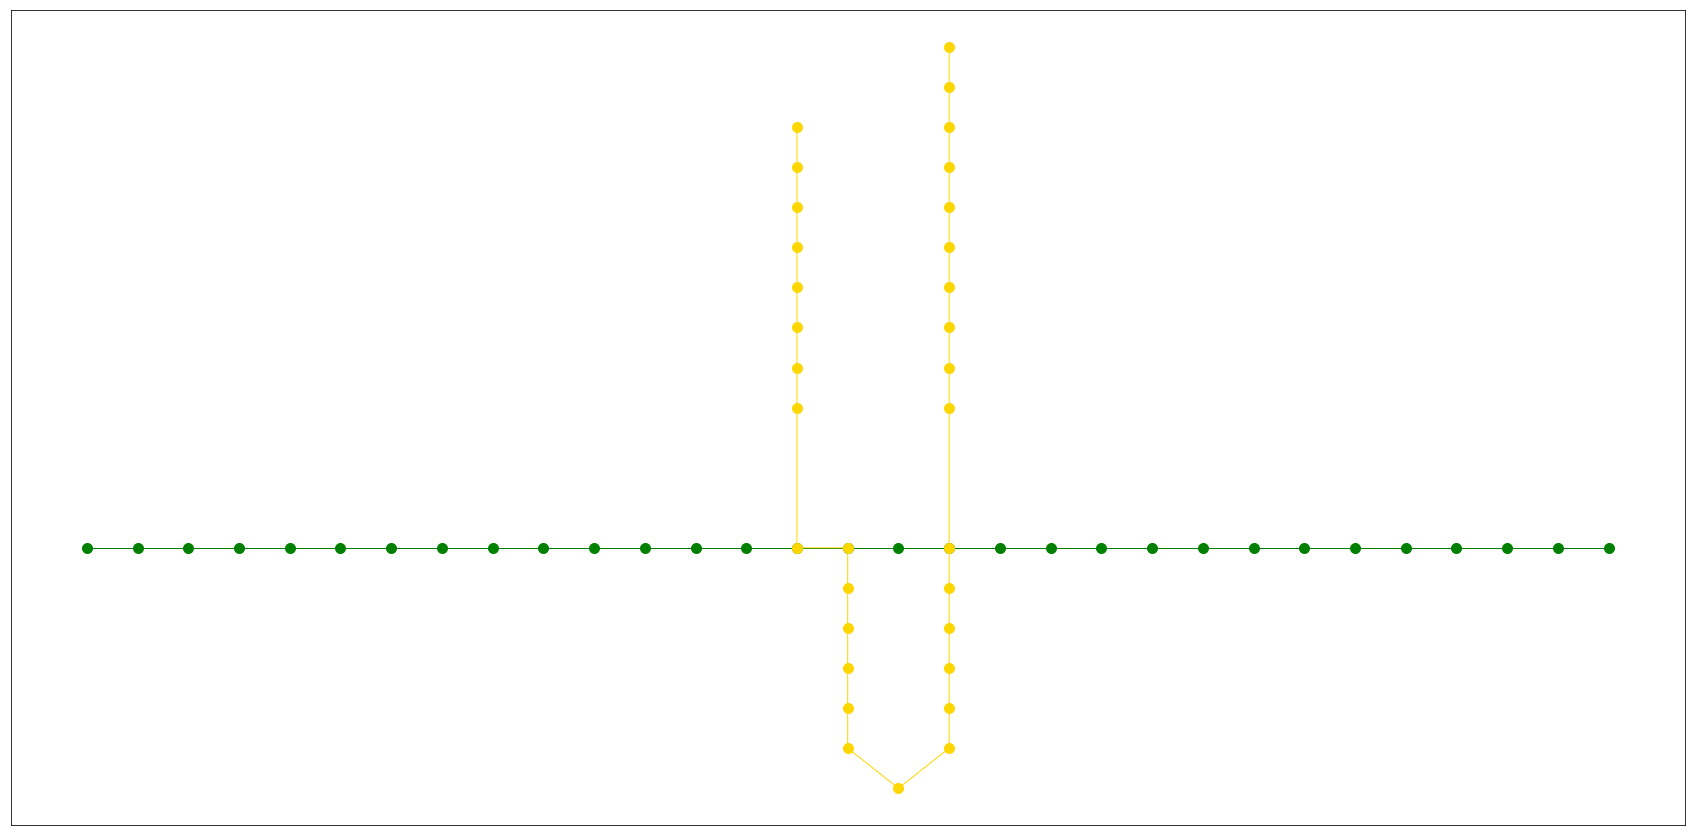

In [154]:
plt.figure(figsize=(30,15))
plt.plot(EW_posx,EW_posy,color='g',lw=1)
plt.plot(NS_posx,NS_posy,color='gold',lw=1)
plt.plot(EW_posx,EW_posy,'o',color='g',markersize=10)
plt.plot(NS_posx,NS_posy,'o',color='gold',markersize=10)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

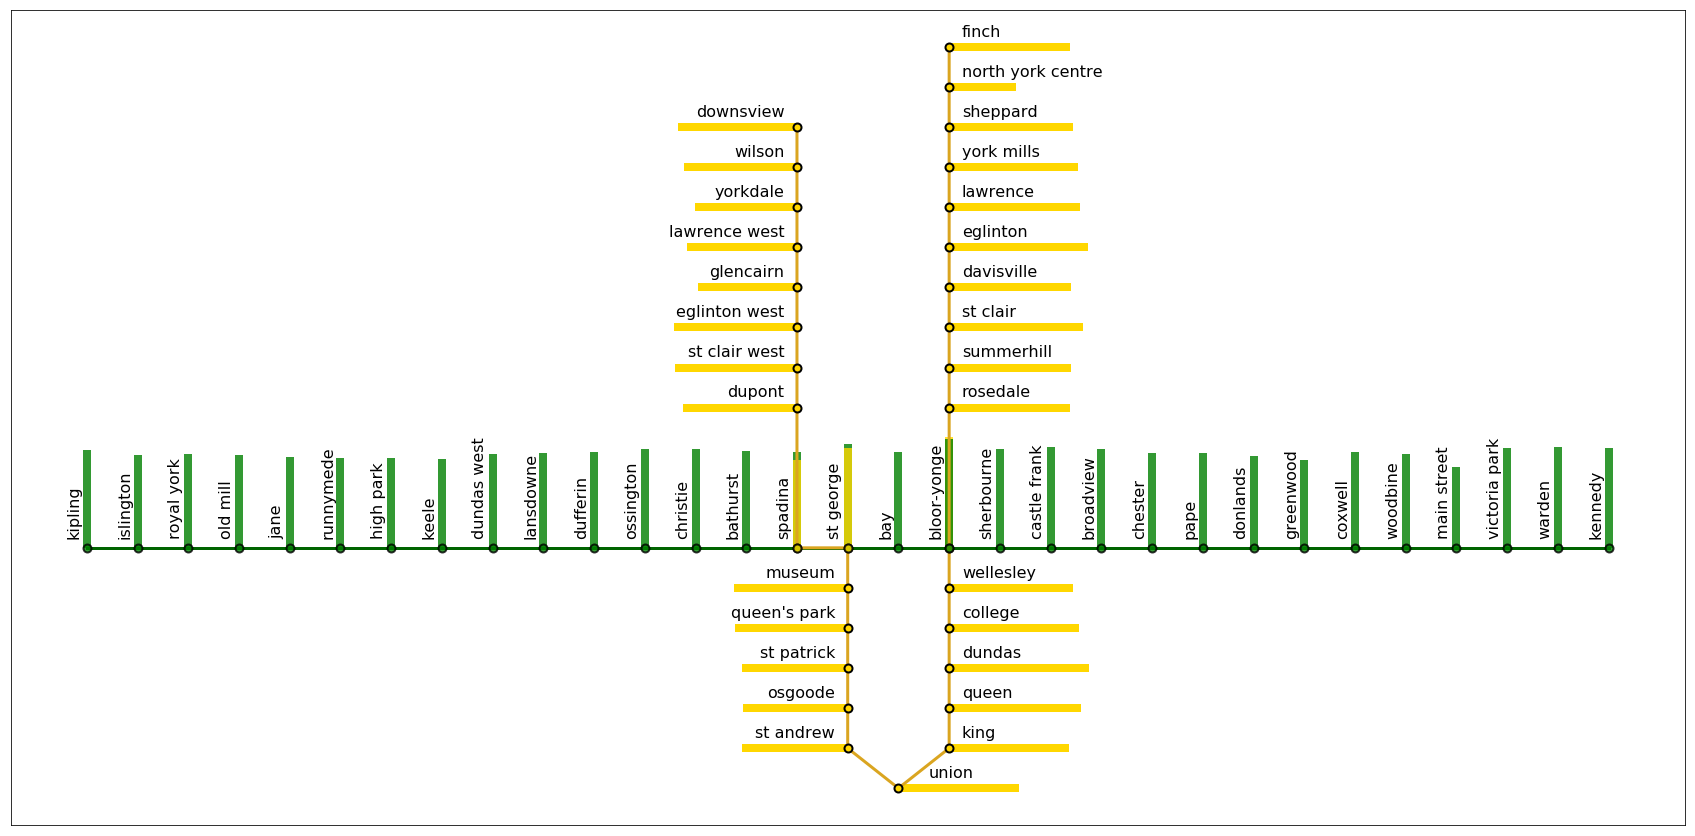

In [161]:
elw = 8
llw = 3
galph = 0.8
yalph = 1
min_delay = np.min(np.concatenate((yus_delays,bd_delays)))
min_size = 8
edge = 2
fs=16
plt.figure(figsize=(30,15))

plt.plot(EW_posx,EW_posy,color='darkgreen',lw=llw)
plt.plot(NS_posx,NS_posy,color='goldenrod',lw=llw)

bd_scaleddelays = np.log10(bd_delays)#/min_delay)

yus_scaleddelays = np.log10(yus_delays)#/min_delay)

# Do Interchanges First

# Spadina
station = 'spadina'
plt.text(EW_posx[bd.index(station)]-0.4*EW_sep,EW_posy[bd.index(station)]+0.25*EW_sep,station,rotation=90,
         fontsize=fs,horizontalalignment='left',verticalalignment='bottom')
if yus_scaleddelays[yus.index(station)] > bd_scaleddelays[bd.index(station)]:
    #plt.plot(NS_posx[yus.index(station)],NS_posy[yus.index(station)],'o',
    #         markersize=yus_scaleddelays[yus.index(station)]+min_size,color='gold',
    #         markeredgecolor='k',markeredgewidth=edge)
    #plt.plot(EW_posx[bd.index(station)],EW_posy[bd.index(station)],'o',
    #         markersize=bd_scaleddelays[bd.index(station)]+min_size,color='g',
    #         markeredgecolor='k',markeredgewidth=edge)
    plt.errorbar(EW_posx[bd.index(station)],EW_posy[bd.index(station)],yerr = np.array([[0,yus_scaleddelays[yus.index(station)]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                     elinewidth=elw,alpha=galph)  
    plt.errorbar(EW_posx[bd.index(station)],EW_posy[bd.index(station)],yerr = np.array([[0,bd_scaleddelays[bd.index(station)]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='g',
                     elinewidth=elw,alpha=galph)  
elif yus_scaleddelays[yus.index(station)] <= bd_scaleddelays[bd.index(station)]:
    #plt.plot(EW_posx[bd.index(station)],EW_posy[bd.index(station)],'o',
    #         markersize=bd_scaleddelays[bd.index(station)]+min_size,color='g',
    #         markeredgecolor='k',markeredgewidth=edge)
    #plt.plot(NS_posx[yus.index(station)],NS_posy[yus.index(station)],'o',
    #         markersize=yus_scaleddelays[yus.index(station)]+min_size,color='gold',
    #         markeredgecolor='k',markeredgewidth=edge)
    plt.errorbar(EW_posx[bd.index(station)],EW_posy[bd.index(station)],yerr = np.array([[0,bd_scaleddelays[bd.index(station)]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='g',
                     elinewidth=elw,alpha=galph)
    plt.errorbar(EW_posx[bd.index(station)],EW_posy[bd.index(station)],yerr = np.array([[0,yus_scaleddelays[yus.index(station)]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                     elinewidth=elw,alpha=galph)

#St George
station = 'st george'
plt.text(EW_posx[bd.index(station)]-0.4*EW_sep,EW_posy[bd.index(station)]+0.25*EW_sep,station,rotation=90,
         fontsize=fs,horizontalalignment='left',verticalalignment='bottom')
if yus_scaleddelays[yus.index(station)] > bd_scaleddelays[bd.index(station)]:
    #plt.plot(NS_posx[yus.index(station)],NS_posy[yus.index(station)],'o',
    #         markersize=yus_scaleddelays[yus.index(station)]+min_size,color='gold',
    #         markeredgecolor='k',markeredgewidth=edge)
    #plt.plot(EW_posx[bd.index(station)],EW_posy[bd.index(station)],'o',
    #         markersize=bd_scaleddelays[bd.index(station)]+min_size,color='g',
    #         markeredgecolor='k',markeredgewidth=edge)
    plt.errorbar(EW_posx[bd.index(station)],EW_posy[bd.index(station)],yerr = np.array([[0,yus_scaleddelays[yus.index(station)]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                     elinewidth=elw,alpha=galph)  
    plt.errorbar(EW_posx[bd.index(station)],EW_posy[bd.index(station)],yerr = np.array([[0,bd_scaleddelays[bd.index(station)]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='g',
                     elinewidth=elw,alpha=galph)  
elif yus_scaleddelays[yus.index(station)] <= bd_scaleddelays[bd.index(station)]:
    #plt.plot(EW_posx[bd.index(station)],EW_posy[bd.index(station)],'o',
    #         markersize=bd_scaleddelays[bd.index(station)]+min_size,color='g',
    #         markeredgecolor='k',markeredgewidth=edge)
    #plt.plot(NS_posx[yus.index(station)],NS_posy[yus.index(station)],'o',
    #         markersize=yus_scaleddelays[yus.index(station)]+min_size,color='gold',
    #         markeredgecolor='k',markeredgewidth=edge)
    plt.errorbar(EW_posx[bd.index(station)],EW_posy[bd.index(station)],yerr = np.array([[0,bd_scaleddelays[bd.index(station)]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='g',
                     elinewidth=elw,alpha=galph)
    plt.errorbar(EW_posx[bd.index(station)],EW_posy[bd.index(station)],yerr = np.array([[0,yus_scaleddelays[yus.index(station)]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                     elinewidth=elw,alpha=galph) 

plt.text(EW_posx[bd.index('yonge')]-0.4*EW_sep,EW_posy[bd.index('yonge')]+0.25*EW_sep,'bloor-yonge',rotation=90,
         fontsize=fs,horizontalalignment='left',verticalalignment='bottom')    
if yus_scaleddelays[yus.index('bloor')] > bd_scaleddelays[bd.index('yonge')]:
    #plt.plot(NS_posx[yus.index('bloor')],NS_posy[yus.index('bloor')],'o',
    #         markersize=yus_scaleddelays[yus.index('bloor')]+min_size,color='gold',
    #         markeredgecolor='k',markeredgewidth=edge)
    #plt.plot(EW_posx[bd.index('yonge')],EW_posy[bd.index('yonge')],'o',
    #         markersize=bd_scaleddelays[bd.index('yonge')]+min_size,color='g',
    #         markeredgecolor='k',markeredgewidth=edge)
    plt.errorbar(EW_posx[bd.index('yonge')],EW_posy[bd.index('yonge')],yerr = np.array([[0,yus_scaleddelays[yus.index('bloor')]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                     elinewidth=elw,alpha=galph)  
    plt.errorbar(EW_posx[bd.index('yonge')],EW_posy[bd.index('yonge')],yerr = np.array([[0,bd_scaleddelays[bd.index('yonge')]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='g',
                     elinewidth=elw,alpha=galph) 
if yus_scaleddelays[yus.index('bloor')] <= bd_scaleddelays[bd.index('yonge')]:
    #plt.plot(EW_posx[bd.index('yonge')],EW_posy[bd.index('yonge')],'o',
    #         markersize=bd_scaleddelays[bd.index('yonge')]+min_size,color='g',
    #         markeredgecolor='k',markeredgewidth=edge)
    #plt.plot(NS_posx[yus.index('bloor')],NS_posy[yus.index('bloor')],'o',
    #         markersize=yus_scaleddelays[yus.index('bloor')]+min_size,color='gold',
    #         markeredgecolor='k',markeredgewidth=edge)
    plt.errorbar(EW_posx[bd.index('yonge')],EW_posy[bd.index('yonge')],yerr = np.array([[0,bd_scaleddelays[bd.index('yonge')]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='g',
                     elinewidth=elw,alpha=galph)
    plt.errorbar(EW_posx[bd.index('yonge')],EW_posy[bd.index('yonge')],yerr = np.array([[0,yus_scaleddelays[yus.index('bloor')]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                     elinewidth=elw,alpha=galph) 

for station in range(len(bd_scaleddelays)):
    if bd[station] not in interchange:
        #plt.plot(EW_posx[station],EW_posy[station],'o',markeredgecolor='k',markeredgewidth=edge,
        #         markersize=bd_scaleddelays[station]+min_size,color='g')
        plt.errorbar(EW_posx[station],EW_posy[station],yerr = np.array([[0,bd_scaleddelays[station]]]).T,
                     fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='g',
                     elinewidth=elw,alpha=galph)  
        plt.text(EW_posx[station]-0.4*EW_sep,EW_posy[station]+0.25*EW_sep,bd[station],rotation=90,fontsize=fs,
                 horizontalalignment='left',verticalalignment='bottom')


for station in range(len(yus_scaleddelays)):
    if yus[station] not in interchange:
        #plt.plot(NS_posx[station],NS_posy[station],'o',markeredgecolor='k',markeredgewidth=edge,
        #         markersize=yus_scaleddelays[station]+min_size,color='gold')
        if station < turn:
            plt.errorbar(NS_posx[station],NS_posy[station],xerr = np.array([[yus_scaleddelays[station],0]]).T,
                         fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                         elinewidth=elw,alpha=yalph)
            plt.text(NS_posx[station]-0.25*NS_sep,NS_posy[station]+0.2*NS_sep,yus[station],fontsize=fs,
                     horizontalalignment='right',verticalalignment='bottom')
        if station == turn:
            plt.errorbar(NS_posx[station],NS_posy[station],xerr = np.array([[0,yus_scaleddelays[station]]]).T,
                         fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                         elinewidth=elw,alpha=yalph)
            plt.text(NS_posx[station]+0.6*NS_sep,NS_posy[station]+0.2*NS_sep,yus[station],fontsize=fs,
                     horizontalalignment='left',verticalalignment='bottom')
        if station>turn:
            plt.errorbar(NS_posx[station],NS_posy[station],xerr = np.array([[0,yus_scaleddelays[station]]]).T,
                         fmt='o',markeredgecolor='k',markeredgewidth=edge,markersize = min_size,color='gold',
                         elinewidth=elw,alpha=yalph)
            plt.text(NS_posx[station]+0.25*NS_sep,NS_posy[station]+0.2*NS_sep,yus[station],fontsize=fs,
                     horizontalalignment='left',verticalalignment='bottom')

plt.xticks([])
plt.yticks([])